# Optimization for Data Science - HW1

##### Authors: Betti Gianmarco, Marinelli Andrea, Rinaldi Giorgia 


##### DESCRIPTION
The aim of this homework is to implement and compare three algorithms for solving a semi-supervised learning binary classification problem. The algorithms used are:

<ol>
    <li>Gradient descent</li>
    <li>Block coordinate gradient descent with randomized rule</li>
    <li>Block coordinate gradient descent with Gauss-Southwell rule</li>
</ol>
The algorithms have been tested on a synthetically generated 2D point dataset and then on some publicly available datasets.

##### DATASETS
The datasets used to test the implemented algorithms are:

<ul>
    <li><b>Breast Cancer</b>: This dataset contains information about the characteristics of some cells present in digital images of breast tissues. Each record represents a cell and contains data such as the size, shape, and homogeneity of the nucleus. The goal is to classify the cells as benign or malignant based on their characteristics.</li>
    <li><b>Iris</b>: This dataset contains information about three species of iris (Iris setosa, Iris virginica, and Iris versicolor) and their botanical characteristics, such as the length and width of the sepals and petals. The goal is to correctly classify the species based on these characteristics. Here, only 2 species out of 3 have been considered in order to have a binary classification problem. </li>
    <li><b>Diabetes</b>: This dataset contains information about some medical characteristics of patients with diabetes, such as age, BMI, blood pressure, glucose level, etc. The goal is to predict whether a patient will develop diabetes or not based on their medical characteristics.</li>
</ul>

In [1]:
# Here we set some environment variable

# Maximum numbers of iterations (for gradient descent)
NUM_ITERS = 60
# Number of points to generate (in the synthetic dataset)
NUM_POINTS = 1000
# Verbosity
OUTPUT_STEP = 0.10
# Percentage of labeled points 
LABELED_PERCENTAGE = 0.10
# Use the optimized version of BCGM Randomized, using Nesterov
OPTIMIZE_RANDOM = True
# Fixed step size to use in case USE_LIPSCHITZ_CONSTANT is false
STEP_SIZE = 1e-4
# Stopping criterion to prevent the algorithm from running indefinitely
EPSILON = 1e-5
# Use Lipschitz constant for the step size
USE_LIPSCHITZ_CONSTANT = True
# Use the optimized Lipschitz constant for BCGM algorithms, calculatend 
# on the block and not on the whole function 
OPTIMIZE_LIPSCHITZ_CONSTANT_FOR_BCGM = False
# DPI for the `matplotlib` plots
PLOT_DPI=100

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.datasets import load_breast_cancer
import scipy.linalg
import time
from os import path
import pandas as pd

In [3]:
# Ensure that your results are reproducible and consistent across multiple runs of the code.
np.random.seed(2)

## Data preparation
In this section, it's been implemented a function which is responsable to load the chosen dataset. Datasets have been processed so that the algorithms can be applied to them.

In [4]:
# Define the dataset selection function
def select_dataset(dataset):
    """
    Load the chosen dataset. Available datasets: (breast_cancer, iris, diabetes, synthetic).
    If no dataset is specified, synthetic dataset is loaded.
    
    Parameters
    ----------
    dataset : str, optional
        Name of the dataset to load
    
    Returns
    -------
      X : ndarray (m,n)
          Feature matrix, m rows, n columns
      y : ndarray (m,)
          Target labels
    """
    
    if dataset == 'breast_cancer':
        
        # Load breast cancer dataset
        breast_cancer = load_breast_cancer()
        
        # Extract features and labels
        X = breast_cancer['data'].astype('float64')
        y = breast_cancer['target'].astype('float64')
        y[y == 0] = -1
        
    elif dataset == 'iris':
        
        # Load iris dataset
        iris = sns.load_dataset('iris')
        labels = ['setosa', 'virginica']
        iris = iris[iris['species'].isin(labels)]
        
        # Plot data
        #sns.pairplot(iris, hue='species', height=1.5);
        
        # Extract features and labels
        X = iris.drop('species', axis=1)
        X = X.to_numpy().astype('float64')
        y = iris['species']
        y[y == 'setosa'] = 1
        y[y == 'virginica'] = -1
        y = y.to_numpy().astype('float64')
    
    elif dataset == 'diabetes':
        
        # Load diabetes dataset
        data = pd.read_csv(path.join('data', 'diabetes.csv'),
                           sep=',',
                           header=0,
                           na_values={'gender': ['Other']})
        # Process data
        data.loc[data['diabetes'] == 0, 'diabetes'] = -1
        data.loc[data['gender'] == 'Female', 'gender'] = 0
        data.loc[data['gender'] == 'Male', 'gender'] = 1
        data.drop('smoking_history', axis=1,  inplace=True)
        data.dropna(inplace=True)
        
        # Select only the first 1000 rows
        data = data.loc[:1000, :]
        
        # Extract features and labels
        X = data.iloc[:, :-1].to_numpy().astype("float64")
        y = data.iloc[:, -1].to_numpy().astype("float64")
        
    elif dataset == 'synthetic' or dataset == None:
        
        # Load the syntethic dataset
        gen1 = lambda x : x**3 + 5 * x**2 + 2
        gen2 = lambda x : 8 * x**3 + 3 * x**2

        # Generate random data for cluster 1
        cluster1_noise = np.random.normal(scale=0.4 ,size=NUM_POINTS)
        cluster1_x1 = np.random.uniform(low=-1, high=1, size=NUM_POINTS)
        cluster1_x2 = gen1(cluster1_x1) + cluster1_noise
        cluster1_y = np.ones(NUM_POINTS)
        cluster1 = np.column_stack((cluster1_x1, cluster1_x2, cluster1_y))

        # Generate random data for cluster 2
        cluster2_noise = np.random.normal(scale=0.4, size=NUM_POINTS)
        cluster2_x1 = np.random.uniform(low=-1, high=1, size=NUM_POINTS)
        cluster2_x2 = gen2(cluster2_x1) + cluster2_noise
        cluster2_y = np.ones(NUM_POINTS) * -1
        cluster2 = np.column_stack((cluster2_x1, cluster2_x2, cluster2_y))
        
        # Combine the two clusters into one dataset
        data = np.vstack((cluster1, cluster2))

        # Shuffle the data randomly
        np.random.shuffle(data)

        # Plot the data
        plt.scatter(cluster2[:, 0], cluster2[:, 1], s=10, c='#FF4400')
        plt.scatter(cluster1[:, 0], cluster1[:, 1], s=10, c='#5603AD')
        plt.title(f"Synthetic Dataset of {NUM_POINTS} 2D Points")
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2");
        
        # Extract features and labels
        X = data[:, 0:2]
        y = data[:, 2]
    
    return X, y

In [5]:
# Selection and loading of the dataset
dataset = 'diabetes'

print('Available datasets: breast_cancer, iris, diabetes, synthetic')
print()
print(f'Trying to load {dataset} dataset...')

try:
    X, y = select_dataset(dataset)
    print(f'...{dataset} dataset loaded')
except:
    print(f'{dataset} is not a valid dataset')
    print('Choose an available dataset')

Available datasets: breast_cancer, iris, diabetes, synthetic

Trying to load diabetes dataset...
...diabetes dataset loaded


In [6]:
# Split the data to get l labeled examples and u unlabeled examples
X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X, 
                                                                  y, 
                                                                  train_size=LABELED_PERCENTAGE, 
                                                                  test_size=(1-LABELED_PERCENTAGE), 
                                                                  random_state=42)
print(f"Original size of X = {X.shape[0]}\tUnlabeled size = {X_unlabeled.shape[0]}\tlabeled size = {X_labeled.shape[0]}")
print(f"Original size of y = {y.shape[0]}\tUnlabeled size = {y_unlabeled.shape[0]}\tlabeled size = {y_labeled.shape[0]}")

Original size of X = 1001	Unlabeled size = 901	labeled size = 100
Original size of y = 1001	Unlabeled size = 901	labeled size = 100


In [7]:
# Assign random labels to unlabeled examples
y_unlabeled_initial = np.random.choice([-1, 1], size=len(X_unlabeled))

In [8]:
# Plot labeled data 
if dataset == 'synthetic' or X_labeled.shape[1] == 2:
    # Plot the data
    def point_color(label):
        if label == 1:
            return '#5603AD'
        else:
            return '#FF4400'
    colors = np.vectorize(point_color)

    plt.scatter(X_unlabeled[:, 0], X_unlabeled[:, 1], s=30, c='grey')
    plt.scatter(X_labeled[:, 0], X_labeled[:, 1], s=30, c=colors(y_labeled))
    plt.title(f"Synthetic Dataset of {NUM_POINTS} 2D Points")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

### Similarity Measure function and weights
The given weight function is defined using the <b>Euclidean distance</b> between pairs of examples in the input space:


$$
w(x,y) = {e^{- 10 \ ||x-y||_{2}^{2} }}
$$


This weight function is a similarity metric that assigns a weight to each pair of examples based on their distance in the input space. It gives higher weight to pairs of examples that are close to each other in the input space, and lower weight to pairs of examples that are far apart. 

By incorporating this weight function into the unsupervised loss term of the loss function, the model is encouraged to produce similar predictions for pairs of examples that are close to each other in the input space, and dissimilar predictions for pairs of examples that are far apart.

In [9]:
# Define our weight function
def weight(dist):
    """
    Compute the weights matrix.
    
    Parameters
    ----------
    dist : ndarray (m,n)
        Matrix containing the Euclidean distances between pairs of examples

    Returns
    -------
    weights : ndarray (m,n)
        Matrix containing weights assigned to each pair of examples
    """
    return math.e**(-10* dist**2)

# Define weights from labeled and unlabeled examples
distances_labeled_unlabeled = euclidean_distances(X_labeled, X_unlabeled) / X_labeled.shape[1]
w = weight(distances_labeled_unlabeled)

# Define weights from unlabeled and unlabeled examples
distances_unlabeled_unlabeled = euclidean_distances(X_unlabeled, X_unlabeled) / X_unlabeled.shape[1]
w_hat = weight(distances_unlabeled_unlabeled)

### <b>Loss function and its derivative</b>

Loss function:
  $$ \min_{y\in{R^u}} \sum_{i=1}^l\sum_{j=1}^u \omega_{ij}(y^{j}-\bar{y}^{i})^2 + \frac{1}{2} \sum_{i=1}^u\sum_{j=1}^u \bar{\omega}_{ij}(y^{j}-y^{i})^2 $$

Gradient with respect to $y^{j}$:
$$ \begin{align*}
\nabla_{y^j}f(y) &= 2 \sum_{i=0}^l \omega_{ij}(y^j - \bar{y}^i) + 2 \sum_{i=0}^u\bar{\omega}_{ij}(y^j - y^i) \\
& = 2  ( \sum_{i=0}^l \omega_{ij} + \sum_{i=0}^u\bar{\omega}_{ij})y^j - 2 \sum_{i=0}^l \omega_{ij}\bar{y}^i - 2 \sum_{i=0}^u\bar{\omega}_{ij}y^i \\
& = 2  \left[ ( \sum_{i=0}^l \omega_{ij} + \sum_{i=0}^u\bar{\omega}_{ij})y^j -  \sum_{i=0}^l \omega_{ij}\bar{y}^i -  \sum_{i=0}^u\bar{\omega}_{ij}y^i \right]
\end{align*}
$$

$u$ : unlabeled data

$l$ : labeled data

$y$ : predicted label ( parameters)

$\bar{y}$ : determined label

$\omega_{ij}$ : similarity measure matrix between labeled and unlabeled data

$\bar{\omega}_{ij}$ : similarity measure matrix between unlabeled data


In [10]:
# Define the loss function
def loss(y_lab, y_unlab):
    """
    Compute the loss.
    
    Parameters
    ----------
    y_lab : ndarray (l,)
        Array containing the labels of labeled examples
    y_unlab : ndarray (u,)
        Array containing the predicted labels for unlabeled examples

    Returns
    -------
    loss : float
        Computed loss
    """
    
    # Turn numpy array into a column array
    Y = np.copy(y_unlab).astype("float64").reshape((-1,1))
    Y_bar = np.copy(y_lab).astype("float64").reshape((-1,1))
    
    # Compute first term
    Y_minus_Y_bar = Y-Y_bar.T
    Y_minus_Y_bar_sq = np.power(Y_minus_Y_bar, 2)
    labeled_unlabeled_loss_matrix = Y_minus_Y_bar_sq * w.T
    labeled_unlabeled_loss = np.sum(labeled_unlabeled_loss_matrix)

    # Compute second term
    Y_minus_Y = Y-Y.T
    Y_minus_Y_sq = np.power(Y_minus_Y, 2)
    unlabeled_unlabeled_loss_matrix = Y_minus_Y_sq * w_hat.T
    unlabeled_unlabeled_loss = np.sum(unlabeled_unlabeled_loss_matrix)

    return labeled_unlabeled_loss + unlabeled_unlabeled_loss/2

In [11]:
# Compute gradient coefficients
# Results are stored so that it won't be necessary to do this computation again

sum_row_label_unlabel = np.sum(w, axis=0).reshape((-1,1))
sum_row_unlabel_unlabel = np.sum(w_hat, axis=0).reshape((-1,1))

grad_first_coeff_vec = 2 * (sum_row_label_unlabel + sum_row_unlabel_unlabel)
grad_second_coeff_vec = 2 * np.multiply(
    y_labeled.reshape((-1,1)),
    w
).sum(0).reshape((-1,1))

In [12]:
# Define gradient function
def gradient(y_unlab):
    """
    Compute the gradient of the loss function
    
    Parameters
    ----------
    y_unlab : ndarray (u,)
        Labels y_j currently assigned to unlabeled points

    Returns
    -------
    gradient : ndarray (u,)
        Gradient of the loss function w.r.t. the labels y_j
    """
    
    # Turn the numpy array into a column array
    y_unlab = y_unlab.reshape((-1,1))
    
    # Compute third coefficient of the gradient
    third_coeff = 2 * np.multiply(y_unlab, w_hat).sum(0).reshape((-1,1))
    
    return (grad_first_coeff_vec * y_unlab - grad_second_coeff_vec - third_coeff).reshape((-1,))

### Accuracy
Let y be the vector of predicted labels for the unlabeled examples, which are assumed to range between -1 and 1, the labels are mapped to binary values by rounding them to the nearest integer and then scaling them to -1 or 1, using: 

$$
sign_{0}(y^{i}) =
\begin{cases}
    +1 & \textrm{if } y^{i} > 0  \\
    -1 & \textrm{otherwise}
\end{cases}
$$

Binary predictions are then compared to the true labels and the proportion of correct predictions is computed.

So, the accuracy of the prediction is computed using the following function:

In [13]:
# Define the prediction accuracy function
def accuracy(y_predicted):
    """
    Compute the accuracy of the predicted labels for unlabeled examples.
    
    Parameters
    ----------
    y_predicted : ndarray (u,)
        Array containing the predicted labels for unlabeled examples

    Returns
    -------
    accuracy : float
        Accuracy
    """
    
    # Maps the predicted labels to binary values either -1 or 1
    y_predicted = np.where(y_predicted > 0, 1, -1)
    
    # Compares the binary predictions to the true labels
    well_predicted = np.equal(y_predicted, y_unlabeled)
    
    # Computes the proportion of correct predictions
    return np.sum(well_predicted) / len(y_unlabeled)

### Hessian Matrix

Those functions are used to calculate the Hessian matrix and the Lipschitz constat for the whole problem, and for the single variable.
The Hessian is calculated as follows:

$$
\begin{align*}
\text{with: } k\neq j \rightarrow \nabla_{y^jy^k}f(j) &= - 2 \ \bar{\omega}_{kj}\\
\text{with: } k = j \rightarrow \nabla_{y^jy^j}f(j) &= 2 \left[ (\sum_{i=0}^ln \ \omega_{ij}) + (\sum_{i=0}^u\bar{\omega}_{ij}) - \bar{\omega}_{jj} \right]\\
\end{align*}
\\
  {H}_{n\times n} = 2 \ 
  \left[ {\begin{array}{cccc}
    (\sum_{i=0}^l \omega_{i1}) + (\sum_{i=0}^u\bar{\omega}_{i1}) - \bar{\omega}_{11} & -\bar{\omega}_{12} & \cdots & -\bar{\omega}_{1n}\\
    -\bar{\omega}_{21} & (\sum_{i=0}^l \omega_{i2}) + (\sum_{i=0}^u\bar{\omega}_{i2}) - \bar{\omega}_{22} & \cdots & -\bar{\omega}_{2n}\\
    \vdots & \vdots & \ddots & \vdots\\
    -\bar{\omega}_{n1} & -\bar{\omega}_{n2} & \cdots & (\sum_{i=0}^l \omega_{in}) + (\sum_{i=0}^u\bar{\omega}_{in}) - \bar{\omega}_{nn}\\
  \end{array} } \right]
$$

In [14]:
%%time
def hessian_matrix(w, w_hat):
    """
    Compute the hessian matrix of the loss function.
    
    Parameters
    ----------
    w : ndarray (l, u)
        Matrix of weights assigned to pairs of labeled-unlabeled examples
    w_hat : ndarray (u, u)
        Matrix of weights assigned to pairs of unlabeled examples

    Returns
    -------
    hessian : ndarray (u, u)
        Hessian matrix
    """
    
    m = np.copy(-w_hat)
    for i in range(len(y_unlabeled)):
        m[i][i] =  np.sum(w[:,i]) + np.sum(w_hat[:,i]) - w_hat[i][i]
    return 2 * m

def estimate_lipschitz_constant(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(len(hessian)-1, len(hessian)-1))[0][0]
def estimate_degree_strongly_convex(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(0,0))[0][0]

if USE_LIPSCHITZ_CONSTANT:
    print("Computing the Hessian matrix\n")
    hessian = hessian_matrix(w, w_hat)
    print("Computing sigma (strongly convex)")
    sigma = estimate_degree_strongly_convex(hessian)
    strongly_convex = sigma > 0
    print(f"Sigma: {sigma}, {'' if strongly_convex else 'not'} strongly convex\n")
    print("Estimating Lipschitz constant for the whole function")
    L = estimate_lipschitz_constant(hessian)
    print(f"Lipschitz constant: {L}")
    print("Estimating Lipschitz constant for each single variable")
    Li = np.array([hessian[i][i] for i in range(len(hessian))], dtype='float64') \
        if OPTIMIZE_LIPSCHITZ_CONSTANT_FOR_BCGM \
        else np.repeat(L, len(hessian))
else:
    print("Using fixed step size")
    sigma = 0
    strongly_convex = False
    L = 1/STEP_SIZE
    Li = np.repeat(L, len(y_unlabeled))
print()

Computing the Hessian matrix

Computing sigma (strongly convex)
Sigma: -4.7082839393756755e-16, not strongly convex

Estimating Lipschitz constant for the whole function
Lipschitz constant: 14.596369574268534
Estimating Lipschitz constant for each single variable

CPU times: user 247 ms, sys: 9.24 ms, total: 256 ms
Wall time: 150 ms


## Gradient Descent

In [15]:
y_unlabeled_gd = y_unlabeled_initial.copy()

In [16]:
%%time

# Apply Gradient Descent Method
ticks_gd = [0]
iters_gd = [0]
accuracies_gd = [accuracy(y_unlabeled_gd)]
losses_gd = [loss(y_labeled, y_unlabeled_gd)]
init_time = time.time() * 1000
for i in range(NUM_ITERS):
    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f"Iteration n.{i: 3} ", end="")
    start = time.process_time()
    grad = gradient(y_unlabeled_gd)

    if EPSILON >= np.linalg.norm(grad):
        break

    y_unlabeled_gd = y_unlabeled_gd - 1/L * grad
    accuracies_gd.append(accuracy(y_unlabeled_gd))
    losses_gd.append(loss(y_labeled, y_unlabeled_gd))
    ticks_gd.append(time.time() * 1000 - init_time)
    iters_gd.append(i)

    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f"\tAccuracy: {(accuracies_gd[-1])*100:.2f}%\t Loss {loss(y_labeled, y_unlabeled_gd):.2f}")
print(f"""
Final accuracy: {round(accuracies_gd[-1]* 100, 2):.2f}%
Gradient Norm: {np.linalg.norm(gradient(y_unlabeled_gd)):.2f}
Loss: {loss(y_labeled, y_unlabeled_gd):.2f}
""")

Iteration n.  0 	Accuracy: 48.83%	 Loss 472.42
Iteration n.  6 	Accuracy: 52.83%	 Loss 109.25
Iteration n. 12 	Accuracy: 56.60%	 Loss 63.09
Iteration n. 18 	Accuracy: 58.82%	 Loss 46.23
Iteration n. 24 	Accuracy: 59.93%	 Loss 37.39
Iteration n. 30 	Accuracy: 61.82%	 Loss 31.87
Iteration n. 36 	Accuracy: 64.04%	 Loss 28.08
Iteration n. 42 	Accuracy: 64.93%	 Loss 25.30
Iteration n. 48 	Accuracy: 65.82%	 Loss 23.19
Iteration n. 54 	Accuracy: 66.26%	 Loss 21.52

Final accuracy: 66.48%
Gradient Norm: 1.73
Loss: 20.39

CPU times: user 2.21 s, sys: 154 ms, total: 2.37 s
Wall time: 2.28 s


In [17]:
# Plot predicted data after gradient descent ( in case of "syntethic" data and with two features)
if  (dataset == 'syntethic') or X_labeled.shape[1] == 2:
    plt.figure(dpi=PLOT_DPI)
    plt.title("Unlabeled points outcome for gradient descent")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    final_y_unlabeled = (y_unlabeled_gd/2 + .5).round() * 2 - 1
    plt.scatter([p[0] for p in X_unlabeled[final_y_unlabeled == 1]], [p[1] for p in X_unlabeled[final_y_unlabeled == 1]], s=10, c='#FF4400')
    plt.scatter([p[0] for p in X_unlabeled[final_y_unlabeled == -1]], [p[1] for p in X_unlabeled[final_y_unlabeled == -1]], s=10, c='#5603AD')

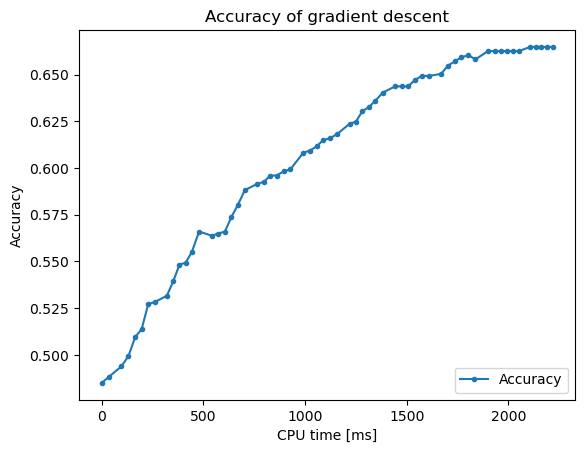

In [18]:
# Plot accuracy of gradient vs CPU time
plt.figure(dpi=PLOT_DPI)
plt.title("Accuracy of gradient descent")
plt.xlabel("CPU time [ms]")
plt.ylabel("Accuracy")
plt.plot(ticks_gd, accuracies_gd, marker='.')
plt.legend(["Accuracy"], loc='lower right');

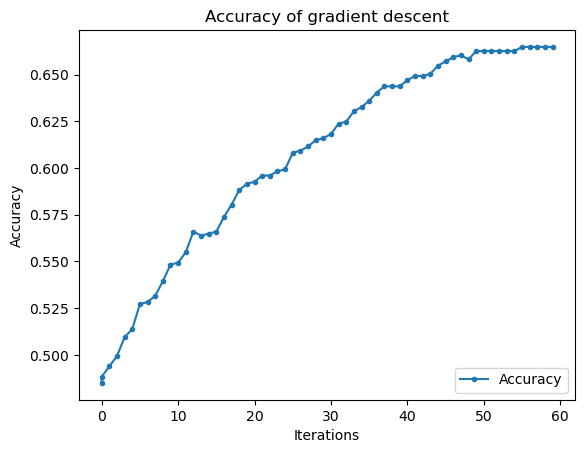

In [19]:
# Plot accuracy of gradient vs number of iterations
plt.figure(dpi=PLOT_DPI)
plt.title("Accuracy of gradient descent")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.plot(iters_gd, accuracies_gd, marker='.')
plt.legend(["Accuracy"], loc='lower right');

## Block Coordinate Gradient Descent

In [20]:
# Partial Derivative of the Loss Function wrt y_j
def derivative(unlabeled, j):
    ''' Partial Derivative of the Loss Function wrt y_j '''
    return 2 * ( grad_first_coeff_vec[j] * unlabeled[j] - \
           grad_second_coeff_vec[j] - \
           np.matmul(w_hat[:,j], unlabeled.T))

In [21]:
# Index generator function
def index_generator(unlabeled):
    if OPTIMIZE_RANDOM:
        return np.random.choice(a=len(unlabeled), p=optimized_sampling_probabilities)
    else:
        return np.random.randint(low=0, high=len(unlabeled))

### Randomized BCGD


In [22]:
y_unlabeled_bcgd_random = np.copy(y_unlabeled_initial).astype("float64")

In [23]:
%%time
# Apply Randomized Block Coordinate Gradient Descent method
ticks_bcgd_random= [0]
iters_bcgd_random = [0]
accuracies_bcgd_random= [accuracy(y_unlabeled_bcgd_random)]
losses_bcgm_random = [loss(y_labeled, y_unlabeled_bcgd_random)]

optimized_sampling_probabilities = np.copy(Li) / np.sum(Li)
grad_bcgd_random = gradient(y_unlabeled_bcgd_random)
max_iterations = NUM_ITERS*len(y_unlabeled_bcgd_random)

init_time = time.time() * 1000

for i in range(max_iterations):
    
    # Print accuracy and loss to keep track of convergence
    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f"Iteration n.{i: 6} ", end="")
    
    # Randomly generate an index
    index = index_generator(y_unlabeled_bcgd_random)
    # Compute the step for the chosen coordinate
    step = 1/Li[index] * grad_bcgd_random[index]
    # Coordinate update
    y_unlabeled_bcgd_random[index] = y_unlabeled_bcgd_random[index] - step
    # Compute the new gradient
    grad_bcgd_random[index] = derivative(y_unlabeled_bcgd_random, index)  
    
    # Stopping rule: check if gradient norm is sufficiently small
    if EPSILON >= np.linalg.norm(grad_bcgd_random):
        break

    if (i+1) % len(y_unlabeled) == 0:

        accuracies_bcgd_random.append(accuracy(y_unlabeled_bcgd_random))
        losses_bcgm_random.append(loss(y_labeled, y_unlabeled_bcgd_random))
        ticks_bcgd_random.append(time.time() * 1000 - init_time)
        iters_bcgd_random.append(i)

    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f"\t Accuracy: {(accuracies_bcgd_random[-1])*100:.2f}%\tLoss {loss(y_labeled, y_unlabeled_bcgd_random):.2f}")
        
print(f"""
Final accuracy: {round(accuracies_bcgd_random[-1]* 100, 2):.2f}%
Gradient norm: {np.linalg.norm(gradient(y_unlabeled_bcgd_random)):.2f}
Loss: {loss(y_labeled, y_unlabeled_bcgd_random):.2f}
""")

Iteration n.     0 	 Accuracy: 48.50%	Loss 899.45
Iteration n.  5406 	 Accuracy: 55.83%	Loss 73.93
Iteration n. 10812 	 Accuracy: 63.60%	Loss 50.97
Iteration n. 16218 	 Accuracy: 68.81%	Loss 49.33
Iteration n. 21624 	 Accuracy: 71.14%	Loss 49.18
Iteration n. 27030 	 Accuracy: 74.81%	Loss 49.16
Iteration n. 32436 	 Accuracy: 78.02%	Loss 49.23
Iteration n. 37842 	 Accuracy: 80.13%	Loss 49.21
Iteration n. 43248 	 Accuracy: 82.91%	Loss 49.21
Iteration n. 48654 	 Accuracy: 84.35%	Loss 49.18

Final accuracy: 85.13%
Gradient norm: 7.07
Loss: 49.19

CPU times: user 5.29 s, sys: 138 ms, total: 5.43 s
Wall time: 5.49 s


In [24]:
# Plot predicted data after Randomized BCGD (in case of "syntethic" data or with two features)
if (dataset == 'syntethic') or X_labeled.shape[1] == 2:
    plt.figure(dpi=PLOT_DPI)
    plt.title("Unlabeled points outcome for Randomized BCGD")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    final_y_unlabeled = (y_unlabeled_bcgd_random/2 + .5).round() * 2 - 1
    plt.scatter([p[0] for p in X_unlabeled[final_y_unlabeled == 1]], [p[1] for p in X_unlabeled[final_y_unlabeled == 1]], s=10, c='#FF4400')
    plt.scatter([p[0] for p in X_unlabeled[final_y_unlabeled == -1]], [p[1] for p in X_unlabeled[final_y_unlabeled == -1]], s=10, c='#5603AD')

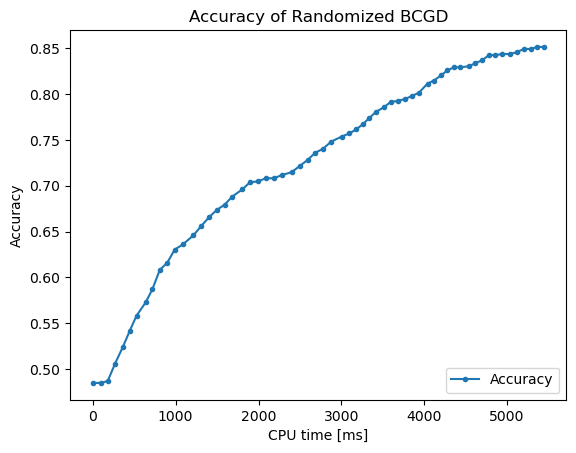

In [25]:
# Plot accuracy of gradient vs CPU time
plt.figure(dpi=PLOT_DPI)
plt.title("Accuracy of Randomized BCGD")
plt.xlabel("CPU time [ms]")
plt.ylabel("Accuracy")
plt.plot(ticks_bcgd_random, accuracies_bcgd_random, marker='.');
plt.legend(["Accuracy"], loc='lower right');

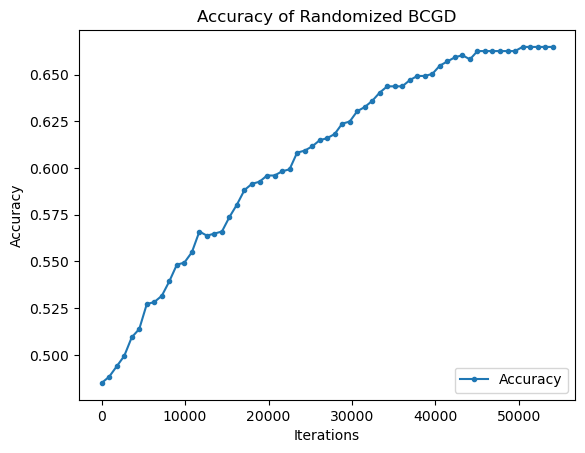

In [26]:
# Plot accuracy of gradient vs number of iterations
plt.figure(dpi=PLOT_DPI)
plt.title("Accuracy of Randomized BCGD")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.plot(iters_bcgd_random, accuracies_gd, marker='.')
plt.legend(["Accuracy"], loc='lower right');

## Gauss-Southwell BCGD

In [27]:
y_unlabeled_bcgd_gs = np.copy(y_unlabeled_initial).astype("float64")

In [28]:
%%time
# Apply Gauss-Southwell Block Coordinate Gradient Descent method
ticks_bcgd_gs = [0]
iters_bcgd_gs = [0]
accuracies_bcgd_gs = [accuracy(y_unlabeled_bcgd_gs)]
losses_bcgm_gs = [loss(y_labeled, y_unlabeled_bcgd_gs)]

max_iterations = NUM_ITERS*len(y_unlabeled_bcgd_random)
grad_bcgd_gs = gradient(y_unlabeled_bcgd_gs)

init_time = time.time() * 1000

for i in range(max_iterations):
    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f"Iteration n.{i: 6} ", end="")

    # Compute the index    
    index = np.argmax(np.abs(grad_bcgd_gs))
    # Compute the step for the chosen coordinate
    step = 1/L * grad_bcgd_gs[index]
    # Coordinate update
    y_unlabeled_bcgd_gs[index] = y_unlabeled_bcgd_gs[index] - step
    # Compute the new gradient
    grad_bcgd_gs[index] = derivative(y_unlabeled_bcgd_gs, index) 

    if EPSILON >= np.linalg.norm(grad_bcgd_gs):
        break

    if (i+1) % len(y_unlabeled) == 0:

        accuracies_bcgd_gs.append(accuracy(y_unlabeled_bcgd_gs))
        losses_bcgm_gs.append(loss(y_labeled, y_unlabeled_bcgd_gs))
        ticks_bcgd_gs.append(time.time() * 1000 - init_time)
        iters_bcgd_gs.append(i)

    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f"\t Accuracy: {(accuracies_bcgd_gs[-1])*100:.2f}%\tLoss {loss(y_labeled, y_unlabeled_bcgd_gs):.2f}")

print(f"""
Final accuracy: {round(accuracies_bcgd_gs[-1]* 100, 2):.2f}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_bcgd_gs)):.2f}
Loss: {loss(y_labeled, y_unlabeled_bcgd_gs):.2f}
""")

Iteration n.     0 	 Accuracy: 48.50%	Loss 888.68
Iteration n.  5406 	 Accuracy: 61.04%	Loss 59.67
Iteration n. 10812 	 Accuracy: 67.37%	Loss 53.57
Iteration n. 16218 	 Accuracy: 71.25%	Loss 51.13
Iteration n. 21624 	 Accuracy: 76.14%	Loss 49.96
Iteration n. 27030 	 Accuracy: 77.58%	Loss 49.68
Iteration n. 32436 	 Accuracy: 80.69%	Loss 49.52
Iteration n. 37842 	 Accuracy: 83.02%	Loss 49.10
Iteration n. 43248 	 Accuracy: 84.57%	Loss 49.46
Iteration n. 48654 	 Accuracy: 85.90%	Loss 49.47

Final accuracy: 87.01%
Norm gradient: 7.13
Loss: 49.55

CPU times: user 3.39 s, sys: 141 ms, total: 3.53 s
Wall time: 3.58 s


In [29]:
# Plot predicted data after Gauss-Southwell BCGD ( in case of "syntethic" data and with two features)
if (dataset == 'syntethic') or X_labeled.shape[1] == 2:
    plt.figure(dpi=PLOT_DPI)
    plt.title("Unlabeled points outcome for Gauss-Southwell BCGD")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    final_y_unlabeled = (y_unlabeled_bcgd_gs/2 + .5).round() * 2 - 1
    plt.scatter([p[0] for p in X_unlabeled[final_y_unlabeled == 1]], [p[1] for p in X_unlabeled[final_y_unlabeled == 1]], s=10, c='#FF4400')
    plt.scatter([p[0] for p in X_unlabeled[final_y_unlabeled == -1]], [p[1] for p in X_unlabeled[final_y_unlabeled == -1]], s=10, c='#5603AD')

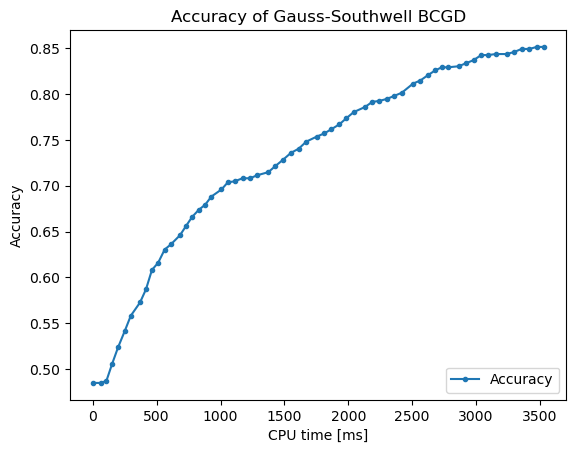

In [30]:
# Plot accuracy of gradient vs CPU time
plt.figure(dpi=PLOT_DPI)
plt.title("Accuracy of Gauss-Southwell BCGD")
plt.xlabel("CPU time [ms]")
plt.ylabel("Accuracy")
plt.plot(ticks_bcgd_gs, accuracies_bcgd_random, marker='.');
plt.legend(["Accuracy"], loc='lower right');

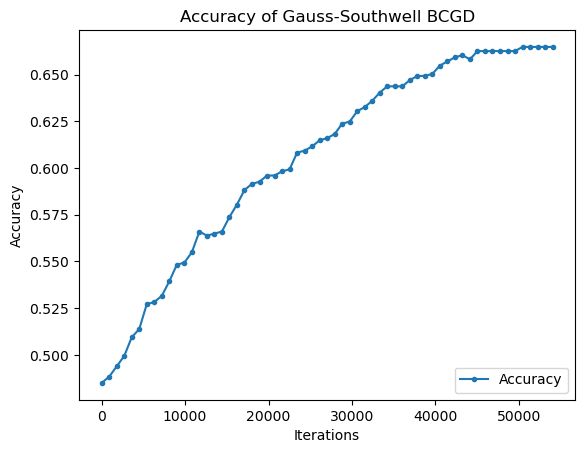

In [31]:
# Plot accuracy of gradient vs number of iterations
plt.figure(dpi=PLOT_DPI)
plt.title("Accuracy of Gauss-Southwell BCGD")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.plot(iters_bcgd_gs, accuracies_gd, marker='.')
plt.legend(["Accuracy"], loc='lower right');

# Comparison of the Methods

### Analyse of accuracy as a function of CPU time

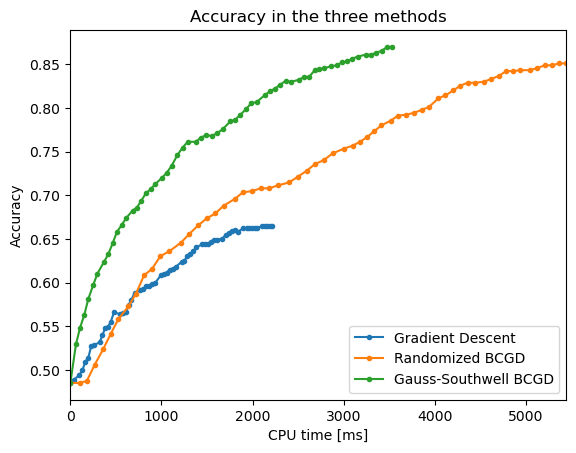

In [32]:
# Plot of accuracy in the three methods as a function of CPU time
plt.figure(dpi=PLOT_DPI)
plt.title("Accuracy in the three methods")
plt.xlabel("CPU time [ms]")
plt.ylabel("Accuracy")
plt.plot(ticks_gd, accuracies_gd, label='Gradient Descent', marker='.')
plt.plot(ticks_bcgd_random, accuracies_bcgd_random, label='Randomized BCGD', marker='.')
plt.plot(ticks_bcgd_gs, accuracies_bcgd_gs, label='Gauss-Southwell BCGD', marker='.');
val = max([ticks_gd[-1], ticks_bcgd_random[-1], ticks_bcgd_gs[-1]])
plt.xlim(-1, val)
plt.legend(loc='lower right');

### Analyse of accuracy as a function of the itaration numbers

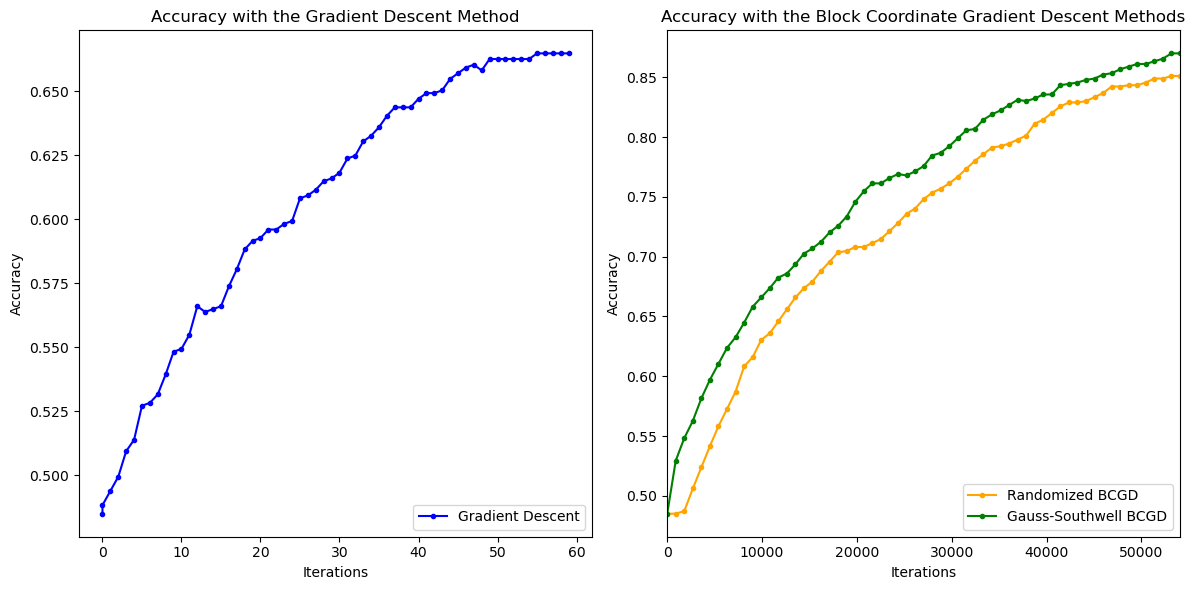

In [33]:
# Plot of accuracy in the three methods as a function of the itaration numbers

# Creation of figure and define the dimension of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=PLOT_DPI)

# Creation of first subgraph 
ax1.set_title("Accuracy with the Gradient Descent Method")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Accuracy")
ax1.plot(iters_gd, accuracies_gd, label='Gradient Descent', color='blue', marker='.')
ax1.legend(loc='lower right')

# Creation of second subgraph 
ax2.set_title("Accuracy with the Block Coordinate Gradient Descent Methods")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Accuracy")
ax2.plot(iters_bcgd_random, accuracies_bcgd_random, label='Randomized BCGD', color='orange', marker='.')
ax2.plot(iters_bcgd_gs, accuracies_bcgd_gs, label='Gauss-Southwell BCGD', color='green', marker='.')
ax2.legend(loc='lower right')
val = max(iters_bcgd_random[-1], iters_bcgd_gs[-1])
ax2.set_xlim([0, val])

# Plot the subplots
plt.tight_layout()
plt.show()